In [26]:
import os
import glob
from datetime import datetime

import pandas as pd
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image

import urllib.request
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange

from sklearn.metrics import confusion_matrix

!pip install exif
from exif import Image as exif

from google.colab import drive
drive.mount('/content/gdrive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
model_path = '/content/gdrive/MyDrive/Colab Notebooks/Training_Log/' + 'CY' + '/epoch_10_2022-08-30 10:38:20.984264.pt'

In [28]:
label_dict = {
    'Aglaonema_commutatum': 0,
     'Asplenium_nidus': 1,
     'Calathea_orbifolia': 2,
     'Chamaedorea_elegans': 3,
     'Dracaena_reflexa': 4,
     'Dracaena_trifasciata': 5,
     'Dypsis_lutescens': 6,
     'Epipremnum_aureum': 7,
     'Hoya_carnosa': 8,
     'Maranta_leuconeura': 9,
     'Monstera_deliciosa': 10,
     'Nephrolepis_cordifolia': 11,
     'Pachira_aquatica': 12,
     'Peperomia_argyreia': 13,
     'Peperomia_obtusifolia': 14,
     'Philodendron_gloriosum': 15,
     'Rhapis_excelsa': 16,
     'Schefflera_arboricola': 17,
     'Tradescantia_zebrina': 18,
     'Zamioculcas': 19
}

In [29]:
label_list = [k for k in label_dict]
label_list

['Aglaonema_commutatum',
 'Asplenium_nidus',
 'Calathea_orbifolia',
 'Chamaedorea_elegans',
 'Dracaena_reflexa',
 'Dracaena_trifasciata',
 'Dypsis_lutescens',
 'Epipremnum_aureum',
 'Hoya_carnosa',
 'Maranta_leuconeura',
 'Monstera_deliciosa',
 'Nephrolepis_cordifolia',
 'Pachira_aquatica',
 'Peperomia_argyreia',
 'Peperomia_obtusifolia',
 'Philodendron_gloriosum',
 'Rhapis_excelsa',
 'Schefflera_arboricola',
 'Tradescantia_zebrina',
 'Zamioculcas']

## Dataset

In [30]:
class GreenFingerDataset(Dataset):

    def __init__(self, data_path, label_dict, oversample=False, transforms=None, rotate=False):
        # retrieve jpg file path from directory: training/validation/testing
        self.files = sorted(glob.glob(os.path.join(data_path, "*/*.jpg")))
        # convert jpg file path to dataframe and attach true label
        self.df = pd.DataFrame(
            dict(
                cat=[f.split('/')[-2] for f in self.files],
                image_path=self.files
            )
        )
        # copy dataframe
        self.df_oversampled = self.df.copy()
        # process oversample function
        if oversample:
            self.oversample()
        # initialize transform procedure
        self.transforms = transforms
        # initialize true label numbering
        self.label_dict = label_dict
        self.rotate = rotate

    def oversample(self):
        """
        This functions can be called or 
        initialized automatically when the oversample=True
        """
        # Random sampling til the # of sample matches to the # of largest category
        cats = self.df.cat.drop_duplicates().to_numpy()
        cat_sizes = []

        for c in cats:
            n = len(self.df.query(f"cat == '{c}'"))
            cat_sizes.append(n)

        cat_sizes = np.array(cat_sizes)
        dfs = []
        n_majority = np.max(cat_sizes)

        for i, c in enumerate(cats):
            df_cat = self.df.query(f"cat == '{c}'").sample(frac=n_majority/cat_sizes[i], replace=True)
            dfs.append(df_cat)

        self.df_oversampled = pd.concat(dfs, axis=0).reset_index(drop=True)

    def __len__(self):
        return len(self.df_oversampled)

    def __getitem__(self, idx):
        img_src, cat = self.df_oversampled.iloc[idx][["image_path", "cat"]]
        # What's the difference between torchvision's readimage and PIL's Image.open?
        x = Image.open(img_src)
        
        if self.rotate:
            with open(img_src, "rb") as f:
                img_exif = exif(f)

            if int(img_exif.orientation) == 6:
                x = x.rotate(-90)
        
        # x = read_image(img_src)
        if self.transforms:
            x = self.transforms(x)
        x = x.float()
        if len(x.size()) == 2:
            # when it's multi channels, x.size() shows (Channel, Heigh, Weight)
            # when channel is 1, x.size() shows (Heigh, Weight) w/o channel
            x = x.unsqueeze(0) 
            x = torch.cat((x, x, x), axis=0)
        if cat in self.label_dict:
            y = self.label_dict[cat]
        else:
            y= -1
        y = torch.Tensor([y]).long()
        
        return x, y

In [31]:
# Transform for Validation Dataset
transforms_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(256), # unify all image as square shape
        transforms.Normalize( # tied with pre-trained weights
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]
)

transforms_val

Compose(
    ToTensor()
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(256, 256))
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [32]:
# Validation Dataset
path_sample = '/content/gdrive/MyDrive/Colab Notebooks/Final_data/val'

ds_data = GreenFingerDataset(
    path_sample,
    label_dict,
    transforms=transforms_val
)
print("ds_data", len(ds_data))

ds_data 494


## Network

In [33]:
n_class = 20

In [34]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# model

In [35]:
model.fc = nn.Linear(model.fc.in_features, n_class)
# model

In [36]:
model.load_state_dict(torch.load(model_path, map_location="cpu")["model_state_dict"])

<All keys matched successfully>

## Inference and probability

CPU: 5.69 iters / s

M1: 6.06 iters / s

In [37]:
batch_size = 4

dl_data = DataLoader(
    ds_data,
    shuffle=False,
    batch_size=batch_size,
    drop_last=False,
)

In [38]:
model.eval()

predictions = []

device = torch.device("cpu")
# device = torch.device("mps")

model = model.to(device)

with torch.no_grad():
    for (x, y) in tqdm(dl_data, desc='Validation', position=0, leave=True):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        # To-Do: Optimize Prediction & Accuracy?
        predictions.append(output.cpu().numpy())
    # Compute Validation Accuracy
    probs = np.concatenate(predictions, axis=0)
    probs = np.exp(probs)
    probs = probs / np.sum(probs, axis=1, keepdims=True)
    preds = np.argmax(probs, axis=1)
    y = np.concatenate([item[1].numpy() for item in ds_data])

Validation:   0%|          | 0/124 [00:00<?, ?it/s]

In [39]:
# Initialize transform proceduce for visualizing images
transforms_val_for_viz = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(
            128,
            interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.CenterCrop(128)])

ds_val_for_viz = GreenFingerDataset(
    path_sample,
    label_dict,
    transforms=transforms_val_for_viz)

print("ds_val_for_viz", len(ds_val_for_viz))

# Filter image's indices where preds != y (unmatched items' indices)
idxs_fail = np.where(preds != y)[0]
idxs_pass = np.where(preds == y)[0]

# Filter ds_test_for_viz dataframe with unmatched items
df_fail = ds_val_for_viz.df.filter(items=idxs_fail, axis=0)
df_pass = ds_val_for_viz.df.filter(items=idxs_pass, axis=0)

# Filter preds array with unmatched items
preds_fail = preds[idxs_fail]
preds_pass = preds[idxs_pass]



ds_val_for_viz 494


### Plot wrong predictions

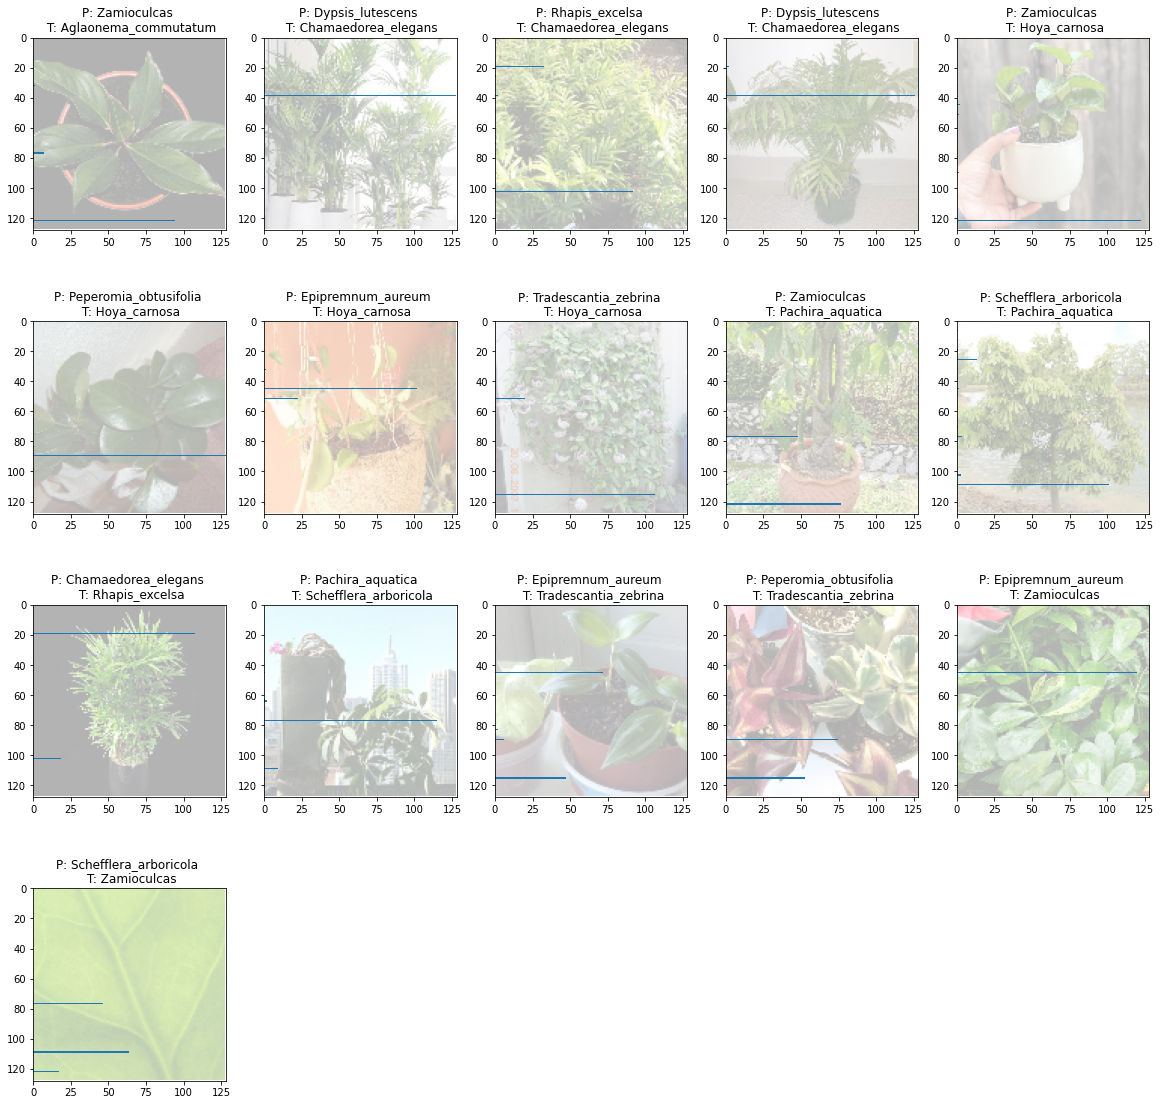

In [40]:
fig = plt.figure(figsize=(20, 20))
fig.patch.set_alpha(1.0)

cols = 4
rows = len(df_fail)//cols + 1

prob_wrong_stat = []

for i in range(len(df_fail)):
    plt.subplot(cols, rows, i+1)
    wrong_ind = idxs_fail[i]
    img, _ = ds_val_for_viz[wrong_ind]
    im = torch.permute(img, [1, 2, 0]).numpy()
    plt.barh(np.arange(n_class)*128/20, probs[wrong_ind]*128)
    plt.imshow(im, alpha=0.3)
    prob_wrong_stat.append(max(probs[wrong_ind]))
    # plt.axis("off")
    plt.xlim(0, 128)
    plt.ylim(128, 0)
    plt.title(f'P: {label_list[preds[wrong_ind]]} \n T: {label_list[y[wrong_ind]]}')


(array([1., 2., 1., 0., 2., 2., 2., 0., 2., 4.]),
 array([0.4983573 , 0.5485059 , 0.59865445, 0.64880306, 0.69895166,
        0.7491002 , 0.7992488 , 0.8493974 , 0.899546  , 0.9496946 ,
        0.9998432 ], dtype=float32),
 <a list of 10 Patch objects>)

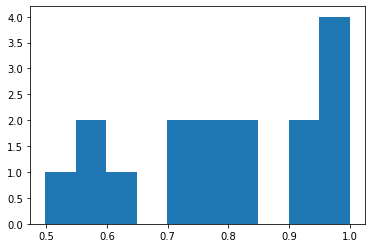

In [41]:
plt.hist(prob_wrong_stat)

Text(0, 0.5, '')

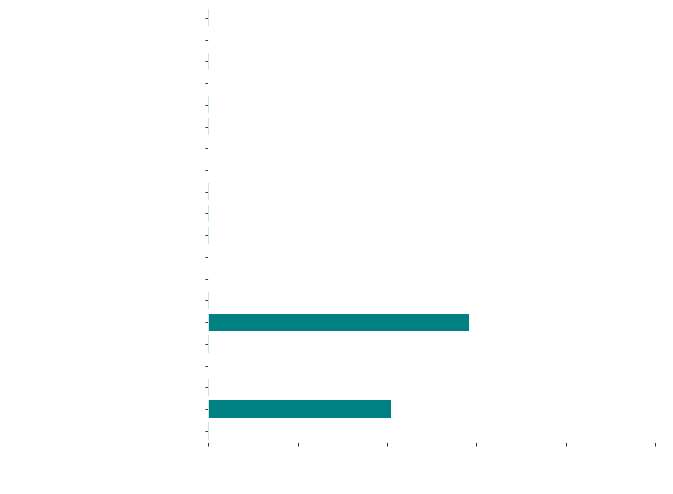

In [77]:
# Plot one example
i = 13

fig, ax = plt.subplots(figsize=(8,8))         

cols = 1
rows = 1

wrong_ind = idxs_fail[i]
ax.barh(label_list, probs[wrong_ind], color='teal')
plt.setp(ax.get_yticklabels(), color='white', fontsize=15)
plt.setp(ax.get_xticklabels(), color='white', fontsize=15)

for spine in ax.spines.values():
        spine.set_edgecolor('white')

ax.patch.set_facecolor('none')

ax.set_xlim(0, 1)
ax.set_ylim(19.5, -0.5)

ax.set_xlabel("Probability", fontsize=20, color='white')
ax.set_ylabel("", fontsize=20, color='white')


### Plot for correct predictions

478
index: 19 | max prob: 0.8974555134773254 | src: Aglaonema_commutatum
index: 47 | max prob: 0.5005847215652466 | src: Asplenium_nidus
index: 88 | max prob: 0.9345327019691467 | src: Dracaena_reflexa
index: 96 | max prob: 0.8685171008110046 | src: Dracaena_reflexa
index: 105 | max prob: 0.5236365795135498 | src: Dracaena_trifasciata
index: 115 | max prob: 0.8471803665161133 | src: Dypsis_lutescens
index: 129 | max prob: 0.9117732048034668 | src: Epipremnum_aureum
index: 131 | max prob: 0.9130629897117615 | src: Epipremnum_aureum
index: 134 | max prob: 0.5419099926948547 | src: Epipremnum_aureum
index: 139 | max prob: 0.9190168380737305 | src: Epipremnum_aureum
index: 144 | max prob: 0.3523666560649872 | src: Epipremnum_aureum
index: 146 | max prob: 0.9085667729377747 | src: Epipremnum_aureum
index: 152 | max prob: 0.8322319388389587 | src: Epipremnum_aureum
index: 174 | max prob: 0.7086106538772583 | src: Hoya_carnosa
index: 193 | max prob: 0.9317159652709961 | src: Hoya_carnosa
inde

(array([  2.,   0.,   3.,   0.,   3.,   2.,   0.,   5.,   8., 455.]),
 array([0.35236666, 0.41713   , 0.48189333, 0.54665667, 0.61142   ,
        0.67618334, 0.74094665, 0.80571   , 0.8704733 , 0.9352367 ,
        1.        ], dtype=float32),
 <a list of 10 Patch objects>)

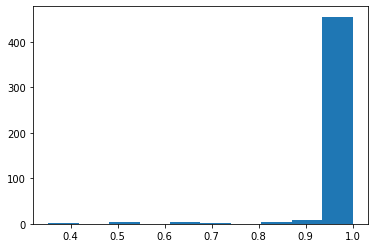

In [42]:
print(len(df_pass))
hight_prob_correct = []
ind_low_prob_correct = []
prob_low_prob_correct = []
for i in range(len(df_pass)):
    correct_ind = idxs_pass[i]
    prob_max = max(probs[correct_ind])
    hight_prob_correct.append(prob_max)
    if prob_max < 0.95:
        ind_low_prob_correct.append(correct_ind)
        prob_low_prob_correct.append(prob_max)
        print(f"index: {correct_ind} | max prob: {prob_max} | src: {label_list[y[correct_ind]]}")

plt.hist(hight_prob_correct)


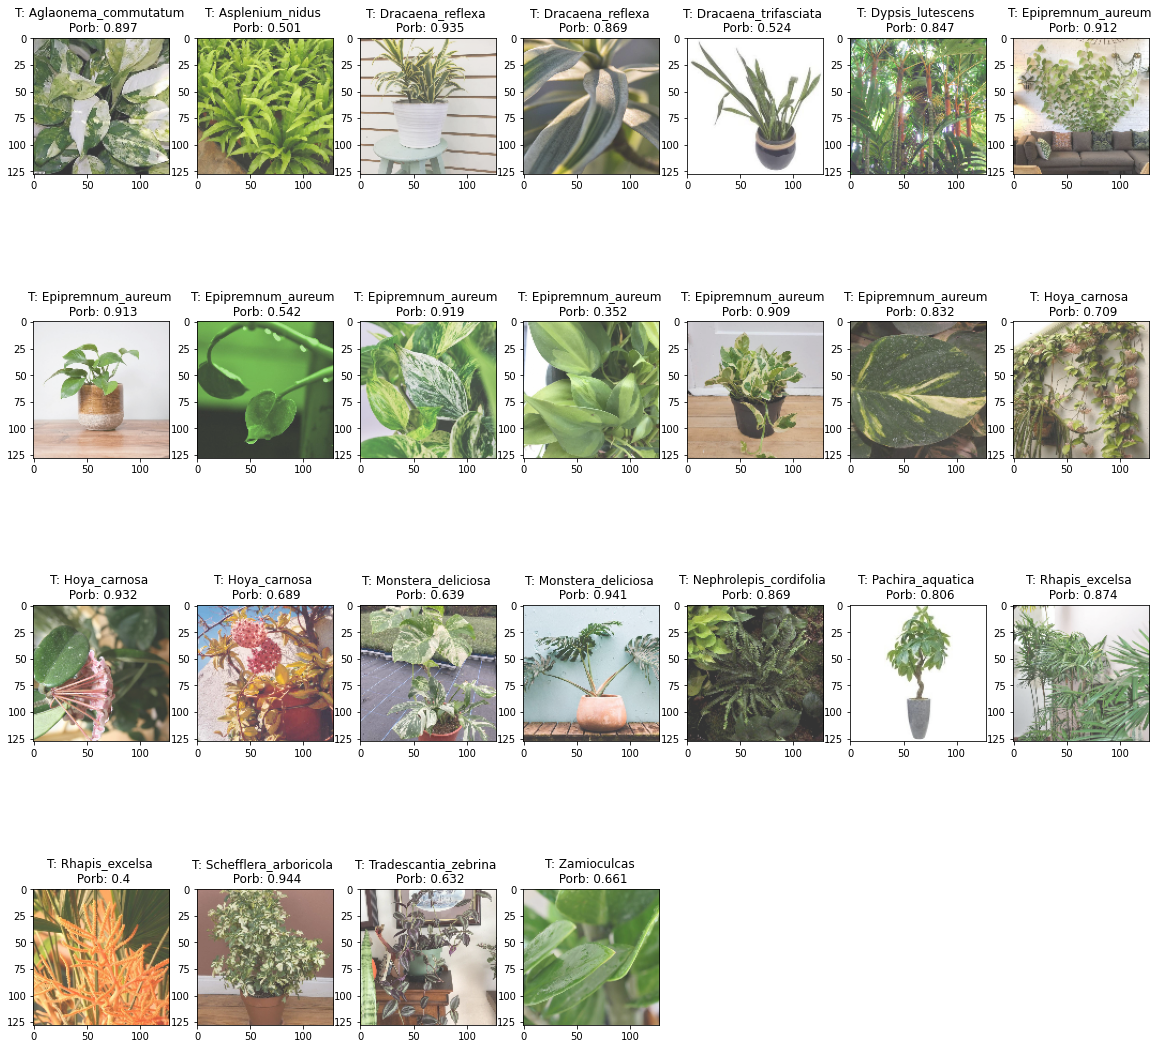

In [43]:
fig = plt.figure(figsize=(20, 20))
fig.patch.set_alpha(1.0)

cols = 4
rows = len(ind_low_prob_correct)//cols + 1

for i in range(len(ind_low_prob_correct)):
    plt.subplot(cols, rows, i+1)
    select_ind = ind_low_prob_correct[i]
    img, _ = ds_val_for_viz[select_ind]
    im = torch.permute(img, [1, 2, 0]).numpy()
    # plt.barh(np.arange(n_class)*128/20, probs[wrong_ind]*128)
    plt.imshow(im, alpha=0.8)

    # plt.axis("off")
    # plt.xlim(0, 128)
    # plt.ylim(128, 0)
    prob_r = round(prob_low_prob_correct[i], 3)
    plt.title(f'T: {label_list[y[select_ind]]} \n Porb: {str(prob_r)}')

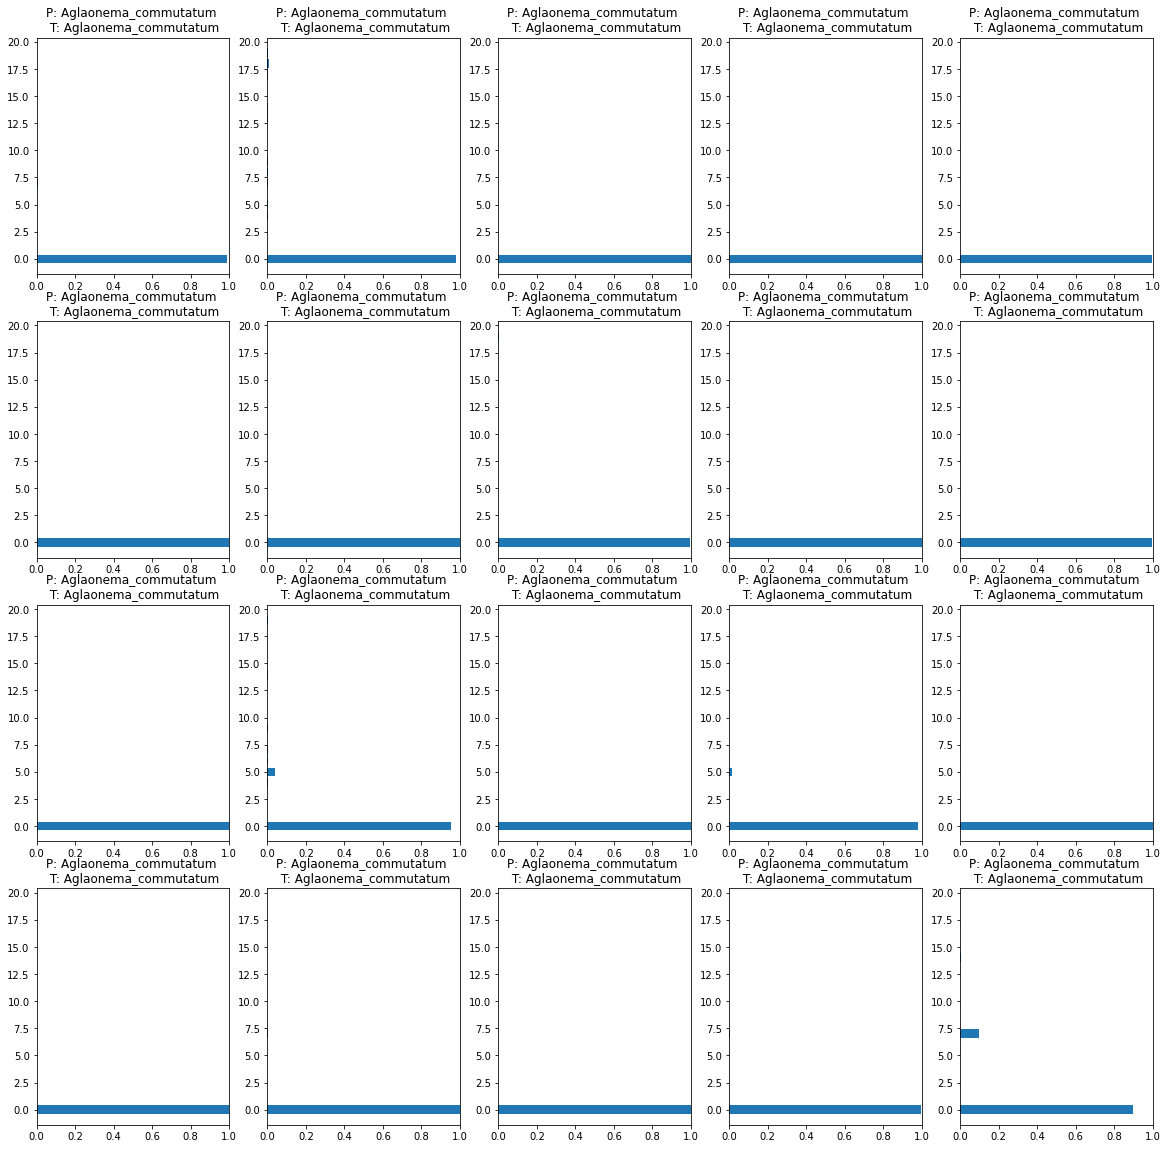

In [44]:
fig = plt.figure(figsize=(20, 20))
# fig.patch.set_alpha(1.0)

cols = 4
rows = len(df_pass)//cols + 1
rows = 5
for i in range(len(df_pass)):
    plt.subplot(cols, rows, i+1)
    correct_ind = idxs_pass[i]
    img, _ = ds_val_for_viz[correct_ind]
    plt.barh(np.arange(n_class), probs[correct_ind])
    # plt.barh(np.arange(n_class)*128/20, probs[correct_ind]*128)
    # im = torch.permute(img, [1, 2, 0]).numpy()
    # plt.imshow(im, alpha=0.3)

    # plt.axis("off")
    plt.xlim(0, 1)
    # plt.xlim(0, 128)
    # plt.ylim(128, 0)
    plt.title(f'P: {label_list[preds[correct_ind]]} \n T: {label_list[y[correct_ind]]}')
    if i+1 == 20:
        break


## Top-k analysis

In [45]:
preds_fail

array([19,  6, 16,  6, 19, 14,  7, 18, 19, 17,  3, 12,  7, 14,  7, 17])

In [46]:
idxs_fail

array([ 32,  79,  81,  85, 159, 166, 183, 204, 315, 321, 378, 392, 411,
       426, 482, 485])

In [47]:
top2_pass = 0
not_in_top2 = []

for i, ind in enumerate(idxs_fail):
    idxs = np.argsort(probs[ind])
    # idxs = np.argsort(probs[ind], axis=1)
    # print(idxs)
    # print(preds_fail[i], idxs[-1], idxs[-2])
    top1 = np.sum(y[ind] == idxs[-1]) 
    top2 = np.sum(y[ind] == idxs[-2])
    if top2 == 0:
        not_in_top2.append(ind)
    # print(top1+top2)
    # print('------')
    top2_pass += top2

print(f"Top-2 testing accuracy: {(len(idxs_pass)+top2_pass)/(len(y))}")

Top-2 testing accuracy: 0.9898785425101214


In [48]:
not_in_top2

[159, 166, 321, 482, 485]

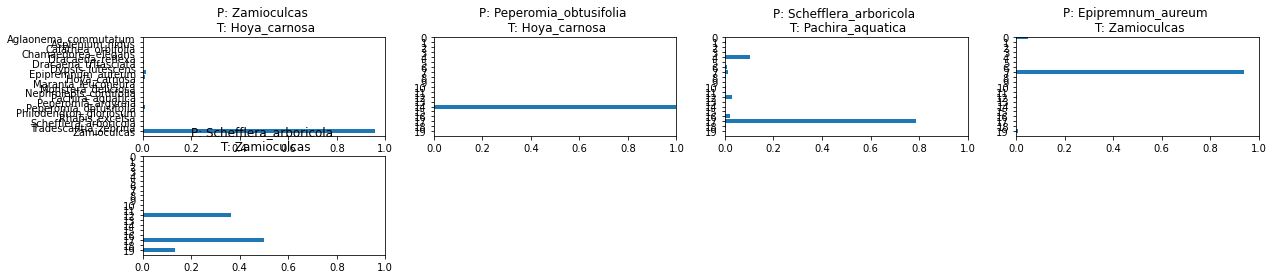

In [49]:
fig = plt.figure(figsize=((20, 4)))
fig.patch.set_alpha(1.0)

cols = 4
rows = len(not_in_top2)//cols + 1

prob_wrong_stat = []

for i in range(len(not_in_top2)):
    plt.subplot(rows, cols, i+1)
    wrong_ind = not_in_top2[i]
    img, _ = ds_val_for_viz[wrong_ind]
    im = torch.permute(img, [1, 2, 0]).numpy()
    plt.barh(np.arange(n_class), probs[wrong_ind])
    if i == 0:
        plt.yticks(np.arange(n_class), labels=label_list)
    else:
        plt.yticks(np.arange(n_class))
    # plt.barh(np.arange(n_class)*128/20, probs[wrong_ind]*128)
    # plt.imshow(im, alpha=0.3)
    prob_wrong_stat.append(max(probs[wrong_ind]))
    # plt.axis("off")
    plt.xlim(0, 1)
    plt.ylim(20, 0)
    # plt.xlim(0, 128)
    # plt.ylim(128, 0)
    plt.title(f'P: {label_list[preds[wrong_ind]]} \n T: {label_list[y[wrong_ind]]}')


ValueError: ignored

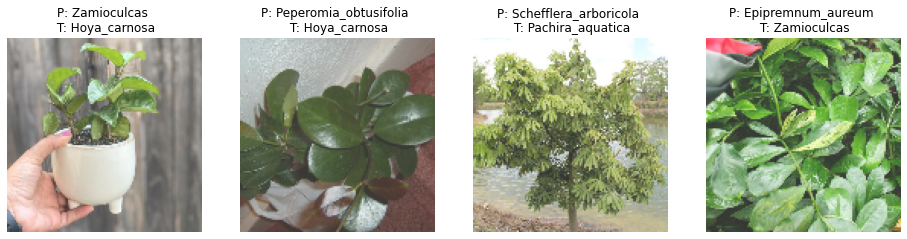

In [50]:
fig = plt.figure(figsize=((16, 4)))
fig.patch.set_alpha(1.0)

cols = 4
rows = len(not_in_top2)//cols 

prob_wrong_stat = []

for i in range(len(not_in_top2)):
    plt.subplot(rows, cols, i+1)
    wrong_ind = not_in_top2[i]
    img, _ = ds_val_for_viz[wrong_ind]
    im = torch.permute(img, [1, 2, 0]).numpy()
    plt.imshow(im, alpha=0.8)
    prob_wrong_stat.append(max(probs[wrong_ind]))
    plt.axis("off")
    # plt.xlim(0, 128)
    # plt.ylim(128, 0)
    plt.title(f'P: {label_list[preds[wrong_ind]]} \n T: {label_list[y[wrong_ind]]}')


### Apply probability threshold

In [ ]:
p_accept = 0.95
p_reject = 0.6

model.eval()

predictions = []

device = torch.device("cpu")
# device = torch.device("mps")

model = model.to(device)

with torch.no_grad():
    for (x, y) in tqdm(dl_data, desc='Validation', position=0, leave=True):
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        predictions.append(output.cpu().numpy())
    # Compute Validation Accuracy
    probs = np.concatenate(predictions, axis=0)
    probs = np.exp(probs)
    probs = probs / np.sum(probs, axis=1, keepdims=True)
    preds = np.argmax(probs, axis=1)
    y = np.concatenate([item[1].numpy() for item in ds_data])

In [ ]:
len(probs)

In [ ]:
max_prob_test = np.amax(probs, axis=1)


In [ ]:
idxs_max_prob_test = np.where(max_prob_test<p_reject)[0]
idxs_max_prob_test

In [ ]:
preds

In [ ]:
preds[idxs_max_prob_test] = -1

In [ ]:
preds

## EXIF - change image orientation

http://sylvana.net/jpegcrop/exif_orientation.html

In [ ]:
# with open("datasets/rodrigues/unknown/IMG_0611.JPG", "rb") as f:
#     img_exif = exif(f)

In [ ]:
# int(img_exif.orientation)